In [301]:
#Import useful packages
import numpy as np
import random
import pickle
import pandas as pd
import importlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from scipy.stats import percentileofscore
from scipy import optimize
import random
from collections import Counter
import os

from IPython.core.debugger import set_trace
import seaborn as sns

In [302]:
#create a function that generates a list of probability distributions representing
#the sum of card values for different numbers of cards at hand in a card game

def gen_distribution(thegame):

    #retrieve maximum number of cards from game
    nmax = thegame ['nmax'] 

      
    # initialize a dictionary to store the probability distributions for different numbers of cards at hand
    allpsum_decks = {}


    #calculate unique card values ('xs') and their corresponding counts in the given deck (0,1,2,3,4)
   
    for n in range(nmax): 
        xs, counts = np.unique(thegame[f'deck_{n}'], return_counts = True)

        #compute probability distribution of card values based on their counts in the deck
        ps = counts / sum(counts)

        variable_name = f'deck_{n}'

        # Create a Pandas Series and store it in the dictionary
        allpsum_decks[variable_name] = pd.Series(ps, index=xs)

    
        #initiate a loop to calculate probability distributions for different numbers of cards at hand
        for k in range (2, nmax +1):

            #generate an array of possible sum values ('sums') based on the minimum and maximum card values in the deck
            sums = np.arange(min(xs)*k, max(xs)*k + 1)

            #initialise a panda Series filled with zeros and indexed by possible sum values
            psum = pd.Series(np.zeros(len(sums)), index=sums)

            #retrieve the probability distribution ('psum0') from the list ('allpsum') for the previous number of cards at hand
            psum0 = allpsum_decks[variable_name]


        #initiate a loop over the unique card values ('xs') with their corresponding indices ('kx')
        for kx, x in enumerate(xs):

            #initiate a nested loop over the indices of the previous probability distribution ('psum0')
            for x0 in psum0.index.values:

                #update the current probability distribution ('psum') by adding the product of the probability of the previous
                #sum ('psum0[x0]'), the probability of the current card value ('ps[kx]), and the current card value ('x')
                psum[x + x0] += psum0[x0] * ps[kx]

        #append the calculated probability distribution for the current number of cards at hand to the list ('allpsum')       
        allpsum_decks[variable_name].append(psum)

        #for future warning: allpsum_decks[variable_name] = pd.concat([allpsum_decks[variable_name], psum])

    
    #return the list containing the probability distributions for different numbers of cards at hand
    return allpsum_decks



In [303]:
#Create a function to evaluate the current state of the game and determine if a player
#has won, lost or if the outcome is still unknown based on the game parameters and the sum
#of cards drawn so far

#cs: list representing the current state of the game (contains sum of card values drawn so far)
#thegame: a dictionary contianing information about the game, sucas upper and lower bounds for winning
#wether busting is allowed, and the maximum of cards allowed.
def dowin(cs,thegame):

    #extract the game parameters upper and lower bounds for winning
    ub,lb = thegame['ublb']

    #calculate whether the current game state is 'bad' by checking if the sum of card values (sum(cs))
    #exceeds the upper bound (ub) or falls below the lower bound (lb)
    #If either condition is true, 'badnow' is set to 'True'
    badnow =(sum(cs)>=ub) or (sum(cs)<=lb)
    
    outcome=0 #initialise outcome to 0 to indicate unknown outcome
    
    #if the currrent state is 'bad', check if busting is allowed (isbust) or not (not thegame['isbust']) 
    #and the maximum number of cards (len(cs)) has been drawn. If either condition is true, it means the 
    #player has lost and the outcome is set to -1.
    if badnow:
        if thegame['isbust'] or (not thegame['isbust'] and len(cs)==thegame['nmax']):
            outcome=-1 #lost

    #if the current state is not 'bad', check if the maximum number of cards allowed (nmax) has been drawn. 
    #If true, it means the player has reached the end without busting and outcome is set to 1, indicating a win.
    else:
        if len(cs)==thegame['nmax']: #already reaching the end without death
            outcome=1 #win
    return outcome

In [304]:
#Create function to calculate the probability to win at each stage of drawing cards in the game
#considering deck composition, upper and lower bounds for winning, and whether busting is allowed
#returns the resulting probabilities in allpwin

def gen_pwin(thegame):

    #retrive maximum number of cards allowed, ub, lb, and whether busting is allowed
    nmax=thegame['nmax']
    ub,lb = thegame['ublb']
    isbust = thegame['isbust']
    # initialize a dictionary to store the probability distributions for different numbers of cards at hand
    allpsum_decks = {}
    allpwin_decks = {}

    #Calculate card probabilities:
    #Calculate the unique card values (xs) and their corresponding counts for each deck (0,1,2,3,4)
    for n in range(nmax): 
        xs,counts = np.unique(thegame[f'deck_{n}'],return_counts=True)

        #compute probability distribution of card values based on their counts in the deck
        ps = counts / sum(counts)

        variable_name = f'deck_{n}'

        # Create a Pandas Series and store it in the dictionary
        allpsum_decks[variable_name] = pd.Series(ps, index=xs)

        #initialise probability table for winning:
        #initialise a list (allpwin) to store the probability of winning at each stage of drawing cards
        #each element corresponds to the probability distribution after drawing a certain number of additional cards (kk)
        allpwin_decks[variable_name]=[[] for kk in range(nmax+1)] # after drawing kk'th card, 
        
        #Calculate initial winning probabilities:
        nmore=0 #initial state where no additional cards are drawn
        N = nmax

        #generate an array of possible sum values (sums) based on the min and max card values in the deck multiplied by the number of cards (N)
        sums = np.arange(-70, 70)

        #compute the initial prob of winning (pwin) for each possible sum value
        #sets the prob to 1 if the sum falls within the winning bounds (ub and lb), otherwise to 0
        pwin = [int(k<ub and k>lb) for k in sums] # p can only be 0 or 1
        
        #store initial pwin prob in allpwin[0]
        allpwin_decks[variable_name][nmore]=pd.Series(pwin,index=sums) 
        
            
        #Calculate winning prob for further points: now start recursive calc
        
        #iterate through the number of additional cards to be drawn (nmore) from 1 to nmax
        #for each nmore, calculate the probability of winning pwin for each possible sum value (sums) based on game state
        for nmore in range(1,nmax+1): #how many more cards to be drawn at most
            N2 = nmax-nmore
            #sums = np.arange(min(xs)*N2,max(xs)*N2+1) #all possible sum values at this point
            pwin=[]
            for s in sums:

                #if busting is allowed, calculate the prob recursiverly considering the prob of previous states (allpwin[nmore-1])
                if isbust:
                    if s>=ub or s<=lb: # bust here!
                        pwin.append(0) #if a bust occurs, pwin is set to 0, indicating a loss
                        continue #skips the remaining code within the loop and moves to next iteration
                    
                    #if a bust has not occured:
                    else:    
                        pw=0

                        #Compute the probability of winning for each possible next card value:
                        #Computes the probability of winning (ps[kx] * allpwin[nmore - 1][s + xnext]) 
                        #for each possible next card value (xnext). It multiplies the probability of 
                        #drawing card value xnext (ps[kx]) with the probability of winning in the previous 
                        #state (allpwin[nmore - 1][s + xnext]) and accumulates the results in pw
                        for kx,xnext in enumerate(xs):
                            pw += ps[kx] * allpwin_decks[variable_name][s+xnext]                    
                        pwin.append(pw)
                
                #if busting is not allowed, calculate the prob based on precomputed prob distributions (allpsum) for all remaining cards
                else:
                    psum = allpsum_decks[variable_name] # probability of the sum of ALL the remaining cards
                    thisp = max(min(sum([psum[smr] for smr in psum.index.values if s+smr<ub and s+smr>lb]),1),0) 
                    pwin.append(thisp)
            
            #After iterating over all possible sum values, it stores the computed probabilities of winning (pwin) in 
            #the allpwin list at index nmore. Each entry in allpwin represents the probability distribution of winning 
            #after drawing a certain number of additional cards (nmore).
            allpwin_decks[variable_name][nmore]=pd.Series(pwin,index=sums)
    
    #set thegame[allpwin] to the computed list of winning probabilities allpwin
    thegame['allpwin'] = [allpwin_decks['deck_0'][0], allpwin_decks['deck_1'][1], allpwin_decks['deck_2'][2]] 
    return  #note, allpwin is indexed by nmore, not how many cards at hand



In [305]:
#Function to calculate the suspense associated with choosing two cards based on L1 norm

#cpair is a tuple containg two card values representing the 2 cards being considered
#cpast is a list representing cards drawn previously
#thegame is a dictionary containing info about game stata and pre-calculated probabilities of winning at each stage (allpwin)
def L1_susp(cpair,cpast,mod,thegame):
    
    #assign a string L1 to the variable 'mod'
    mod = 'L1'

    #retrieve pre-calculated prob of winning
    allpwin = thegame['allpwin']

    #calculate the number of additional cards to be drawn based on the max number of cards allowed and cards drawn so far
    nmore = thegame['nmax'] - len(cpast)

    #compute the sum of card values drawn in previous rounds
    snow = sum(cpast)

    #Retrieve probability of winning associated with the sum of card values for the first card in the pair
    p0=allpwin[nmore-1][snow+cpair[0]]

    #Retrieve probability of winning associated with the sum of card values for the second card in the pair
    p1=allpwin[nmore-1][snow+cpair[1]]

    #Calculate suspense by computing the absolute difference between the prob of winning for the two cards in the pair cpair
    #The difference reprrsents the suspense associated with choosing between the two cards
    susp = np.abs(p0 - p1)

    return susp

In [306]:
#Function to generate a sequence of pairs of cards drawn randomly from the deck
#It checks for conditions that might end the game prematurely and updates game state
#with the generated pair sequence and the outcome of the game.

def gen_pairseq(thegame):

    #extract upper and lower bounds for winning from the game parameters
    ub,lb=thegame['ublb']
    
    #if busting is allowed in game
    if thegame['isbust']:

        #define a lambda function gmdone that returns 'true' if the sum 'x' exceeds the ub or falls under the lb
        gmdone=lambda x: x>=ub or x<=lb  
    
    #if busting is not allowed
    else:

        #define a lambda function gmdone as a lambda function that always returnd false, indicating the game will not end prematurely
        gmdone=lambda x:False
    
    #initialise an empty list to stroe pairs of cards
    pairseq = []

    nmax = thegame['nmax']

    #iterate nmax times
    for n in range(nmax):

        #draw a pair of cards randomly from the deck without replacement
        pair = np.random.choice(thegame[f'deck_{n}'],2,replace=False)
        
        #append the drawn card pair to the pairseq list
        pairseq.append(pair)

        #Update deck by removing the drawn cards from the deck
        #thegame[f'deck_{n+1}'] = [card for card in thegame[f'deck_{n}'] if card not in pair]

        #Store the current deck into the corresponding key (deck_1, deck_2, etc.)
        thegame[f'deck_{n+1}'] = thegame[f'deck_{n}'][:]
    
        # Remove the first card of the pair from the deck
        index = np.where(thegame[f'deck_{n+1}'] == pair[0])[0]
        if len(index) > 0:
            thegame[f'deck_{n+1}'] = np.delete(thegame[f'deck_{n+1}'], index[0])
    
            
        # for some rules, game may end before nmax so need to check
        
        #check for game end, calculate the sum of the first cards in all pairs drawn so far
        if gmdone(sum([p[0] for p in pairseq])):
            break #if game should be ended based on conditions specified by gmdone
    
    #update game state: store the generated pair sequences as a numpy array in the game state under the key pairseq
    thegame['pairseq']=np.array(pairseq)

    #determine the game outcome (win or lose) based on the first card in each paiir in the sequence using the 'dowin' function which assigns +1 (win) or -1 (loss)
    thegame['iswin']=dowin([pr[0] for pr in pairseq],thegame)
    
    return 

In [307]:
#Compute suspense values for different models for each pair

#default model to use is L1
def suscompute(thegame,susmods = ['L1']):
    #given the selected sequences, what are the sus
    #output stored in "thegame"

    #if allpwin key is not present in thegame dictionary, compute the prob of winning for
    #different game states using the gen_pwin function which retrieves the pair 
    if 'allpwin' not in thegame:
        gen_pwin(thegame)
    pairs = thegame['pairseq']
    
    #initialise empty dictionary to store the suspense values for each model
    suscpr = {} # dictionary

    #iterate through each model in susmods
    for m in susmods:

        #initialise empty list for each model in suscpr, where each list will contain the suspense values for each pair in the sequence
        #the length of each list will be the same as the length of the pair sequence.
        suscpr[m]=[[] for k in range(len(pairs))]

    #iterate through pairs
    for n in range(len(pairs)): # how many pairs before finally done
        
        #calculate the remaining number of pairs before game ends
        nmore = thegame['nmax']-n

        #retrieve current pair from the pair sequence
        pair = pairs[n]   

        #iterate through each model specified in susmods                             
        for mod in susmods:

            #compute the suspense value of the current pair, using L1_susp for the specified model ('mod')
            #it considers the first card in all previously drawn pairs (pairs[:n,0]) and passes the game state
            #thegame as an argument
            #this process populates suscpr with suspense values for each model and each pair in the pair sequence
            suscpr[mod][n]=L1_susp(pair,pairs[:n,0],mod,thegame)                    
    
    #update game state with the computed suspense values stored in suspcr
    thegame['suscpr']=suscpr
    return

In [308]:
# test run: generate one game
nmax = 3
decksize = 10
cardran = np.arange(-3,10)
thegame = {'ublb':[3,-100],'nmax':nmax,'isbust':False, 'deck_0':np.random.choice(cardran,decksize)}
# get pairs
gen_pairseq(thegame)

suscompute(thegame)

# get an ordered version of suspense, since we care more about the trend rather than absolute value
# note: we want the susp of same value to be at the exact same order.
susporder = {}
for mod,sus in thegame['suscpr'].items():    
    susporder[mod]=[percentileofscore(sus,s)/100*len(sus) for s in sus] # order but allowing same values sharing same number
thegame['susporder']=susporder

### Single game generation

In [309]:
def plotsusmodcpr(game, mdcpr='',figfile=''): 
    f, axs = plt.subplots(2,1,figsize=(6,6))
    if len(mdcpr)==0:
        mdcpr = game['suscpr'].keys()
    for mod in mdcpr:#game['suscpr'].items():
      
        sus = game['suscpr'][mod]
        axs[0].plot(sus,'--o',label=mod)        
        axs[0].set_ylabel('suspense')
        axs[0].set_ylim(0,1.2)
        
        
        axs[1].plot(game['susporder'][mod],'--o',label=mod)        
        axs[1].set_ylabel('suspense order')
    
    plt.legend()
    pairs = game['pairseq']
    cards = [p[0] for p in pairs]
    for ax in axs:
        ax.set_xticks(np.arange(len(sus)))
        ax.set_xticklabels([[list(np.cumsum(cards)-cards)[k],list(pairs[k])] for k in range(len(pairs))])
    axs[1].set_xlabel('current sum,next pair')
    bust = ['Total','Bust']
    tittx = 'rule: '+bust[game['isbust']]+', '+str(game['ublb'])
    
    f.suptitle(tittx)
    if figfile:
        #plt.show()
        plt.savefig(figfile)
        plt.close()
    else:
        plt.show()




[ 5  3 -1  0 -2 -1  9  3  5  6]
[ 5  3 -1 -2 -1  9  3  5  6]
[ 3 -1 -2 -1  9  3  5  6]


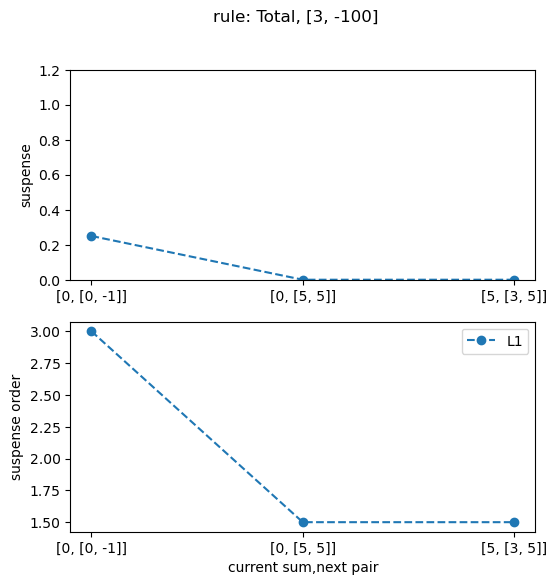

In [310]:
# visualize the game and suspense models
print(thegame['deck_0'])
print(thegame['deck_1'])
print(thegame['deck_2'])

plotsusmodcpr(thegame)


### Generate many games

- Randomly generate many games under a specific rule

In [311]:
# fix the rule: as in paper -> no bust games with upper bound 3 and 3 draws
nmax = 3
decksize = 10

#the range in the exp 2 example seems to be -7 to 7 although it is not explciitly written
cardran = np.arange(-7,7) #card range
ublb = [3,-100]

In [312]:
#Try different decks with no-bust rule

#initialise list of decks with a single predefined deck composition
decks = []
# add 5000 randomly generated decks to the decks list
while len(decks) < 5000:

    #np.random.choice randomly selects elements from cardran array, here the number selected will correspond to decksize
    decks.append(np.random.choice(list(cardran)*2,decksize,replace=False)) #at most 2 repetition per card

# generate games
ngen = 1 #how many games per deck
alldks = []

for deck in decks:
    dkgames = []

    #generate ngen games for the current deck
    
    for kgen in range(ngen):
        
        #set up parameters for the game
        thegame = {'ublb':ublb,'nmax':nmax,'isbust':False, 'deck_0':deck}
       
        #generate pairs of cards for the game
        gen_pairseq(thegame)
        
        #Get suspense
        suscompute(thegame,['L1'])
        
        #Compute suspense order for each model's suspense values
        susporder = {}
        for mod,sus in thegame['suscpr'].items():    
            susporder[mod]=[percentileofscore(sus,s)/100*len(sus) for s in sus] # order but allowing same values sharing same number
        thegame['susporder']=susporder
        #save it
        dkgames.append(thegame)
    alldks.append(dkgames)

In [313]:
len(alldks)

#fix the suscompute problem

5000

### Example just to see the graphs

- Will have to filter games after

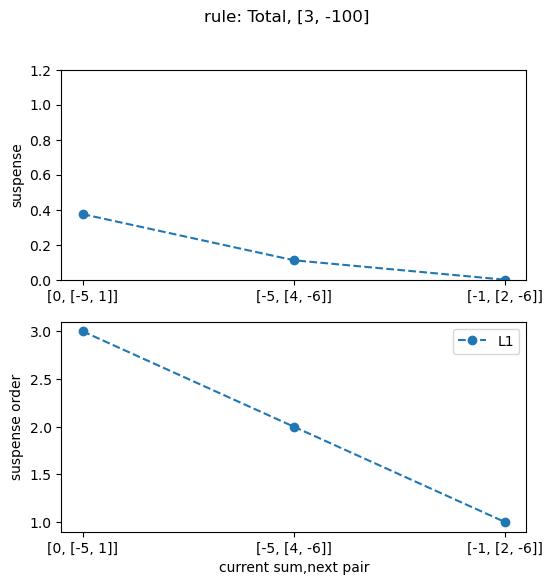

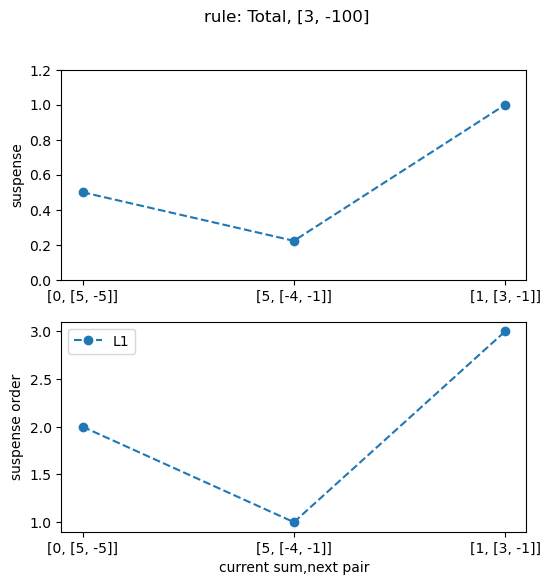

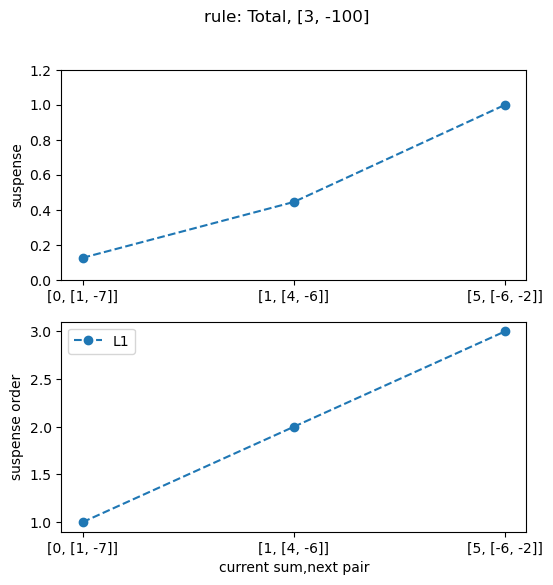

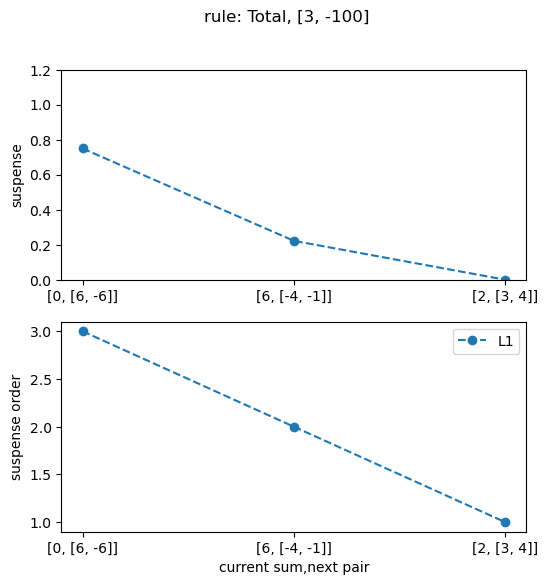

In [314]:
plotsusmodcpr(alldks[2][0])
plotsusmodcpr(alldks[3][0])
plotsusmodcpr(alldks[4][0])
plotsusmodcpr(alldks[5][0])

In [315]:
#pickle.dump is used to srialise python objects into a binary format and write them to a file
#open() will open a file named manydecks... where %d is a placeholder that will be replaced with the value ublb[0]
#the file is opened in binary write model (wb)
#%ublb[0]: This placeholder will be replaced by the value of ublb[0] when the string is formatted. 
#The value of ublb[0] is used to personalize the filename based on some variable in the code.

pickle.dump(alldks,open('manydecksNoRepl3Trials_srange_%dbnd_Apr2_24.p'%ublb[0],'wb'))

### Select the games


In [316]:
alldks = pickle.load(open('manydecksNoRepl3Trials_srange_%dbnd_Apr2_24.p'%ublb[0],'rb'))

In [317]:
#determine the minimum acceptable probability for the occurrence of a card in the game
#the same card shouldn't appear more than 3 times if it only appears once in the deck; any event rarer than that is invalid
criteria =(1/decksize)**3 

In [318]:
#check the validity of a game from dictionary 'gm'
def gmvalid(gm):

    #calculate array cs (unique elements from pairseq array)
    #ccts contains the count of each corresponding element in cs
    cs,ccts = np.unique(gm['pairseq'],return_counts=True)
    
    #calculate array xs (unique elements from deck array)
    #counts contains the count of each corresponding element in xs
    xs,counts = np.unique(gm['deck_0'],return_counts=True)     

    #loop iterating over each unique pair of cards (c) in the pair sequence (cs)
    #k represents the index of the current pair
    for k,c in enumerate(cs):
        
        #calculate the prob pc of drawing current pair of cards from the deck
        #prob is computed based on the count of the card (c) in the deck (counts[xs==c])
        #divided by the tot number of cards in the deck (decksize) raised to the power of the count 
        #of the pair in the pair sequence (ccts[k]) -> check if < or > than criteria
        pc = (counts[xs==c]/decksize)**ccts[k]
        
        #if pc is less than criteria, it means that the occurrence of the card is too rare, incdicating an invalid game -> false
        if pc<criteria:
            return False
    
    #start a loop iterating over each consecutive pair of cards (pr) in the pair sequence 
    for kp,pr in enumerate(gm['pairseq'][:-1]): # no two pairs identical in sequence gm[pairseq] except for the last pair
        
        #if two consecutive pairs are identical, there is a repetion and the game sequence -> invalid game
        if( pr == gm['pairseq'][kp+1]).all():
            return False
    
    #if none og the conditions for invalidity are met, return True -> the game is valid
    return True

In [319]:
#Count the number of badgames

badones = 0
validgms = []

#iterate over each sublist of games in the alldks list
for dkgms in alldks:

    #iterate over each game gm in the current sublist dkgms
    for gm in dkgms:

        #check if gm is valid using the gmvalid function. If yes, it appends it to validgms
        if gmvalid(gm):
            validgms.append(gm)
        
        #if not, it increases the count of badones by 1
        else:
            badones+=1

In [320]:
print(badones)
print(len(validgms))


67
4933


### Bin games by their suspense & outcome

In [321]:
# check suspense distribution -- as expected, declining exponential...(well also looks linear)
allsusp = [np.sum(gm['suscpr']['L1']) for gm in validgms]

#example of how it works for current gm -> makes the sum of the suspense experienced per game
print(gm['suscpr']['L1'])
np.sum(gm['suscpr']['L1'])
len(allsusp) #has the same length as validgms


[0.375, 0.1111111111111111, 0]


4933

In [322]:
#Organise games into bins (with uneven percentiles?) based on the sum of suspense values and the length of pair sequence
#print the number of games in each bin condition 

percenstep = 5 #step size for calculating percentiles

#calculates the percentiles of the allsusp list () thanks to np.percentile()
#[0th, 10th, 45th, 55th, 90th, 100th] percentiles
#susbin array contains the boundaries of the bins
susbin = np.percentile(allsusp,[0,2*percenstep,50-percenstep,50+percenstep,98,100])

#initialise a list with three bins, each containing two empty lists
#each sublist will store games dictionary based on their win or loss status within each bin
gmbins = [[[],[]] for k in range(3)]

#iterate over each game in the validgms list
for gm in validgms:

    #calculate the sum of suspense values for the current game and store it in gmsus
    gmsus = np.sum(gm['suscpr']['L1'])

    #calculate length of the pair sequence for the current game
    gmlen = len(gm['pairseq'])

    #inner loop to iterate over three bins -> low, mid and high suspense
    for kbin in range(3):

        #check if the sum of suspense values for the gm falls within the range of the current bin's boundaries
        #and if the length of the pair sequence is greater than or equal to 3 (length of the sequence)
        if gmsus>=susbin[kbin*2] and gmsus<=susbin[kbin*2+1] and gmlen>=3:
            
            #append the current game to the appropriate sublist of 'gmbins' based on its win or loss status within the current bin
            gmbins[kbin][gm['iswin']==-1].append(gm)
        

#number of games in each bin condition
print([len(thebin) for bins in gmbins for thebin in bins])    

[507, 39, 388, 134, 54, 57]


In [323]:
#winning games list
len(gmbins[0][0])

#losing games list
gmbins[0][1]
#first losing game for bin one (low susp) -> dictionary
gmbins[0][1][0]

{'ublb': [3, -100],
 'nmax': 3,
 'isbust': False,
 'deck_0': array([ 5,  4,  1,  6, -7,  6, -4, -6,  0,  5]),
 'deck_1': array([ 5,  1,  6, -7,  6, -4, -6,  0,  5]),
 'deck_2': array([ 5,  1, -7,  6, -4, -6,  0,  5]),
 'deck_3': array([ 5,  1, -7,  6, -4, -6,  5]),
 'pairseq': array([[4, 6],
        [6, 6],
        [0, 1]]),
 'iswin': -1,
 'allpwin': [-70    1
  -69    1
  -68    1
  -67    1
  -66    1
        ..
   65    0
   66    0
   67    0
   68    0
   69    0
  Length: 140, dtype: int64,
  -70    1.0
  -69    1.0
  -68    1.0
  -67    1.0
  -66    1.0
        ... 
   65    0.0
   66    0.0
   67    0.0
   68    0.0
   69    0.0
  Length: 140, dtype: float64,
  -70    1.0
  -69    1.0
  -68    1.0
  -67    1.0
  -66    1.0
        ... 
   65    0.0
   66    0.0
   67    0.0
   68    0.0
   69    0.0
  Length: 140, dtype: float64],
 'suscpr': {'L1': [0.0, 0.0, 0]},
 'susporder': {'L1': [2.0, 2.0, 2.0]}}

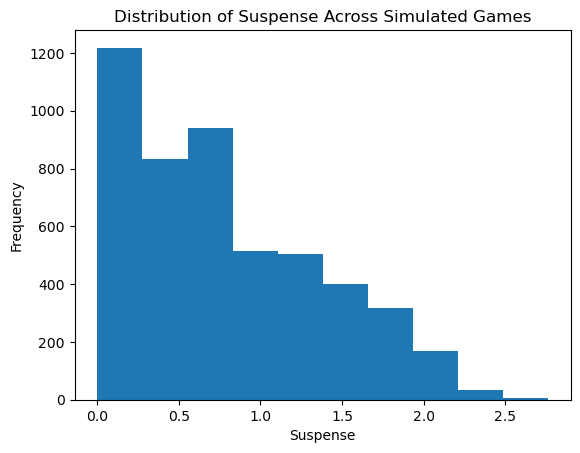

In [324]:
#Plot distribution of overall suspense across simulated games
plt.hist(allsusp)
plt.title('Distribution of Suspense Across Simulated Games')
plt.xlabel('Suspense')
plt.ylabel('Frequency')
plt.show()

#Most games fall into low suspense distrib

### Trim the games so each group contains a similar amount of games

In [325]:
#Function to trim all lists within gmbins to have the same minimum length minbin
#Randomly select elements from each list to create new lists with the same length, and stores these trimmed lists in trimbin

#calculate minimum length among all the lists (thebin) containes within the nested lists (bins) in the variable gmbins
#uses a list comprehension to iterate over each bins list in gmbins, and within each bins list, it iterates over each thebin
#basically fins which of the bin condition has the least games
minbin = min([len(thebin) for bins in gmbins for thebin in bins])

#iterate over each bins list in gmbins using list comprehension
#for each bins list it randomly selects minbin number of elements from the first list (bins[0]) and minbin number of elements from the second list (bins[1])
#this results in a list of lists where each inner list contains 'minbin' number of elements randomly chosen from the corresponding lists in gmbins (winning: bins[0]; losing: bins[1])
trimbin=[[np.random.choice(bins[0],minbin),np.random.choice(bins[1],minbin)] for bins in gmbins]

In [326]:
#Both winning and losing lists of vocabularies now have the same number of elements
#So all bins have the same numbers
len(trimbin[0][0])
len(trimbin[0][1])

len(trimbin[1][0])
len(trimbin[1][1])

len(trimbin[2][0])
len(trimbin[2][1])

39

Text(0.5, 1.0, 'Mean of Suspense Sum Across Conditions')

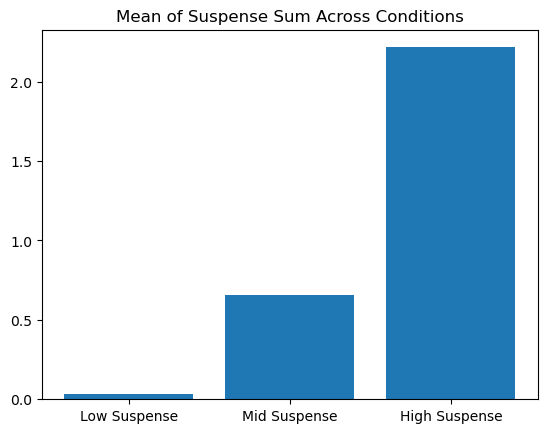

In [327]:
#Check that suspense per bin (low, mid and high) corresponds to what expected

#create empty lists (low, mid, high) 
susarr = [[] for k in gmbins]

#iterate over each element 'bins' in trimbin
for kb,bins in enumerate(trimbin):

    #for each bins, iterate over each element gms in bins
    for gms in bins:

        #for each gms it iterates over each gm in gms
        for gm in gms:

            #calculate the sum of values associated with the key L1 in each gm[suscpr] dictionary, based on index kb
            susarr[kb].append(sum(gm['suscpr']['L1']))

#calculate mean of each sublist in susarr
#bar plot showing the mean of suspense sum per condition (low, mid, high)
plt.bar(np.arange(3),[np.mean(karr) for karr in susarr])
plt.xticks(np.arange(3), ['Low Suspense', 'Mid Suspense', 'High Suspense'])
plt.title('Mean of Suspense Sum Across Conditions')


<module 'matplotlib.pyplot' from '/Users/mariapitteri/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

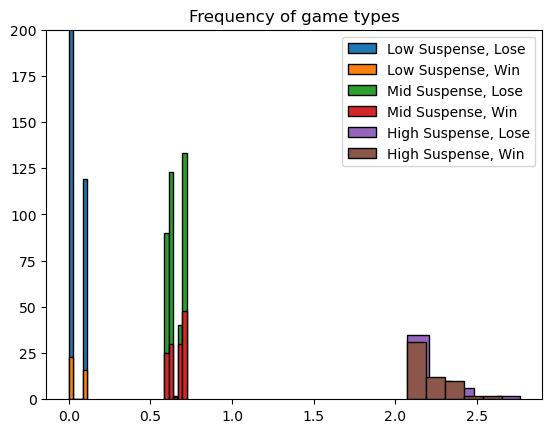

In [328]:
#Divide by winning and losing

suslb=['Low Suspense','Mid Suspense','High Suspense']
winlb = ['Lose','Win']

custom_palette = sns.color_palette("pastel")

for kb,bins in enumerate(gmbins):
    for kk,gms in enumerate(bins):
        plt.hist(pd.Series([sum(gm['suscpr']['L1']) for gm in gms]),label=suslb[kb]+', '+winlb[kk], bins=5, edgecolor='black')
plt.legend()
plt.ylim(0,200)
plt.title('Frequency of game types')
plt

In [329]:
#find a subset of games that meet certain criteria while minimising the difference between max and min cumsum

#minimum numbers of games to pick
minbin = 6

#initialise cumulative sums min and max bounds
mincs = 0
maxcs = 0

#initialise empty list to store the best subset of games
bestbin = []

#track number of repetitions
nrep=0

#initialise a high number
bestdist = 1000

#loop while bestdist is greater than 25 and nrep is less than 2000
while bestdist>25 and nrep<2000:

    #choose a random subset of games (6 winning and 6 loosing) from gmbins (3)
    fingmbins = [[np.random.choice(bins[0],minbin,replace=False),np.random.choice(bins[1],minbin,replace=False)] for bins in gmbins]

    for kbin,gmbs in enumerate(fingmbins):
        for kwin,gmwin in enumerate(gmbs):
            for gm in gmwin:

                #calculate cumulative sum of prob from pairseq
                csum = np.cumsum([pr[0] for pr in gm['pairseq']])
                
                #update mincs and maxcs based on the min and max cumulative sums
                if maxcs<max(csum):
                    maxcs = max(csum)
                if mincs>min(csum):
                    mincs = min(csum)
    
    #cumulative sum distance
    csdist = maxcs-mincs

    #if bestdist is smaller than the csdist
    if bestdist >csdist:

        #bestbin becomes the random three games selected
        bestbin = fingmbins

        #bestdist becomes the csdist
        bestdist = csdist
        print(mincs,maxcs)
    nrep+=1

print(bestdist)

-16 14
30


So, the final output bestdist represents the smallest difference between the maximum and minimum cumulative sums of probabilities across the selected subset of games found during the search. It indicates how well the selected subset of games satisfies the criteria while minimizing variability in cumulative probabilities. The smaller the bestdist, the more uniform the distribution of cumulative probabilities across the selected games.

In [330]:
#Ensure that each deck configuration in the selected subset of games (bestbin) is unique -> no repetitions

#iterate over each indices in bestbin list (the selected games)
for kbin,gmbins in enumerate(bestbin):

    #iterate over the indices of lists of games gwin within each gmbins
    for kwin,gmwin in enumerate(gmbins):

        #kk iterates over the indices of individual games gm within the current list of games
        for kk,gm in enumerate(gmwin):
            
            #check if deck configuration of current game is found in another game within the same list of games gmwin
            if list(gm['deck_0']) in [list(gmwin[kgm]['deck_0']) for kgm in range(len(gmwin)) if kgm != kk]:
                idx = [list(gmwin[kgm]['deck_0']) for kgm in range(len(gmwin)) if kgm != kk].index(list(gm['deck_0']))
                
                #if a repeated configuration is found, find its index and check if cum sum is 0 -> if so it is the same game
                if sum(gmwin[idx]['pairseq'][0]-gm['pairseq'][0])==0:
                    
                    #a bad one if there is repetition -> re-run code
                    print('a bad one')
                    set_trace()

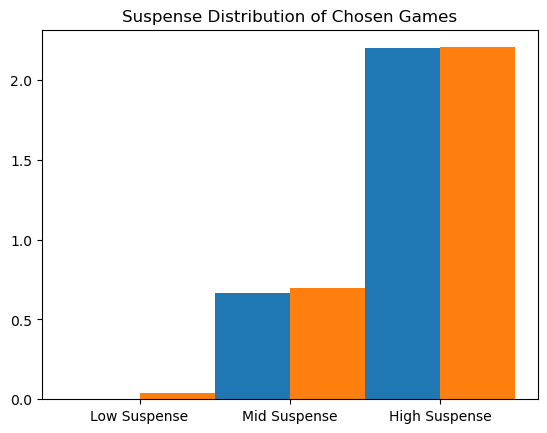

[0.037037037037037035, 0.6944444444444443, 2.2037037037037037]
[[3.0, 3.0], [3.0, 3.0], [3.0, 3.0]]


In [331]:
# show the susp distribution
susarr = [[[],[]] for k in bestbin]
gmlenarr = [[[],[]] for k in bestbin]
for kb,bins in enumerate(bestbin):
    for kwin,gms in enumerate(bins):
        for gm in gms:
            susarr[kb][kwin].append(sum(gm['suscpr']['L1']))
            gmlenarr[kb][kwin].append(len(gm['pairseq']))
        gmlenarr[kb][kwin] = np.mean(gmlenarr[kb][kwin])
plt.bar(np.arange(3),[np.mean(karr[0]) for karr in susarr],width=.5)
plt.bar(np.arange(3)+0.5,[np.mean(karr[1]) for karr in susarr],width=.5)
plt.xticks(np.arange(3)+0.25, ['Low Suspense', 'Mid Suspense', 'High Suspense'])
plt.title('Suspense Distribution of Chosen Games')
plt.show()
print([np.mean(karr[1]) for karr in susarr])
print(gmlenarr)

Understand what this is doing, how it orders the output susarr, does it

In [332]:
#Print cumulative suspense for each game in each bin
for kb,bins in enumerate(fingmbins):
    for kwin,gms in enumerate(bins):
        for gm in gms:
            susarr[kb][kwin].append(sum(gm['suscpr']['L1']))

In [333]:
print(sum(gm['suscpr']['L1']))
print(gm['iswin'])
print(0.46913580246913583 + 0.4444444444444444 + 1)
susarr

#?????

2.416666666666667
-1
1.9135802469135803


[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11111111111111105],
  [0.0,
   0.0,
   0.0,
   0.1111111111111111,
   0.1111111111111111,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.1111111111111111,
   0.0]],
 [[0.6666666666666667,
   0.6111111111111112,
   0.6944444444444444,
   0.7083333333333333,
   0.625,
   0.6944444444444444,
   0.6805555555555556,
   0.5972222222222222,
   0.625,
   0.7222222222222222,
   0.7083333333333335,
   0.625],
  [0.6944444444444444,
   0.6944444444444444,
   0.6666666666666667,
   0.6805555555555556,
   0.7083333333333335,
   0.7222222222222222,
   0.5972222222222222,
   0.7222222222222222,
   0.6666666666666666,
   0.6111111111111112,
   0.6944444444444444,
   0.7083333333333333]],
 [[2.1527777777777777,
   2.3055555555555554,
   2.166666666666667,
   2.1944444444444446,
   2.0694444444444446,
   2.3194444444444446,
   2.1805555555555554,
   2.4027777777777777,
   2.1805555555555554,
   2.1527777777777777,
   2.291666666666667,
   2.20833

[-7 -7  1 -4 -3  1 -5 -6 -2  2]
1


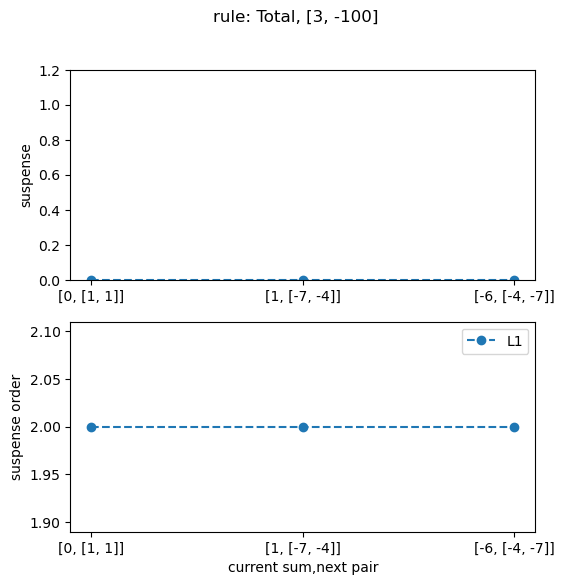

[ 1  0  1 -3 -6  0 -1 -5  3 -1]
1


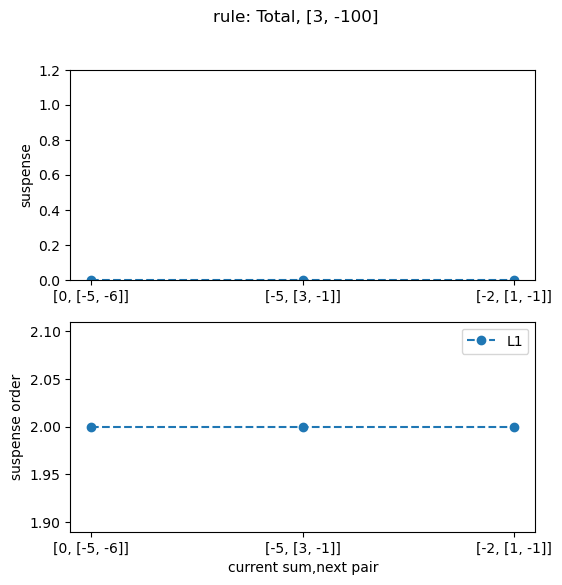

[-4 -5 -4 -3 -3  3  4  6  0  5]
1


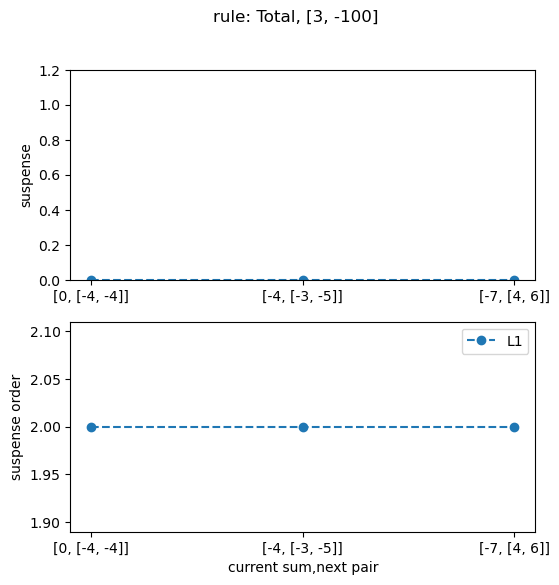

[-3 -1  2 -6 -6 -7 -2 -2 -4 -3]
1


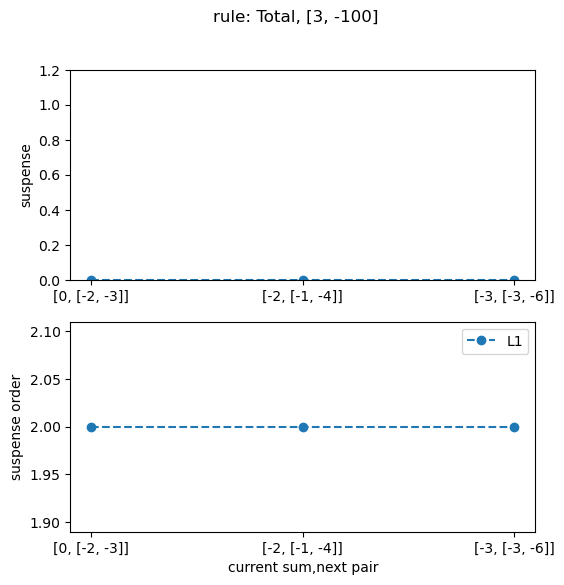

[-7  4 -1  2 -7  0 -6 -3  0 -2]
1


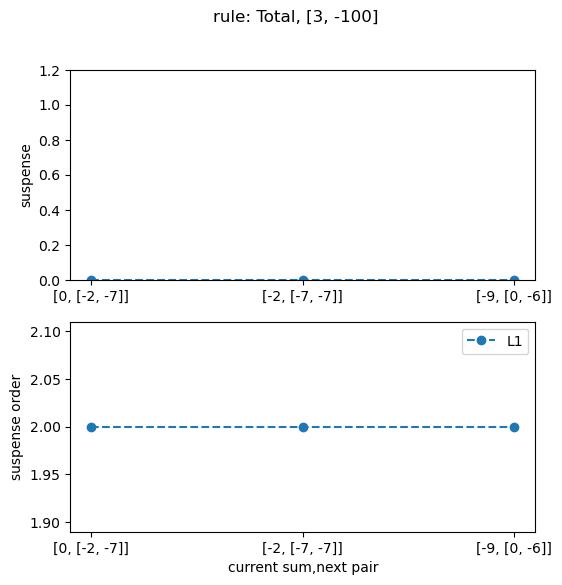

[ 2 -6  0 -7  1 -5 -5  3 -3 -1]
1


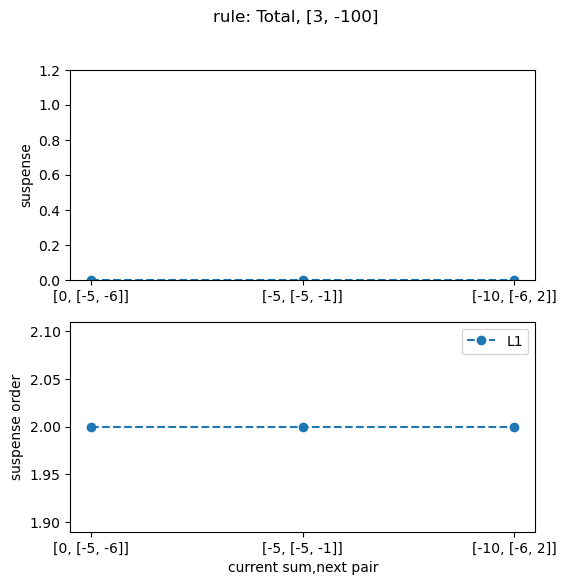

[ 5  1  2 -3  1 -6  5 -7 -5  6]
-1


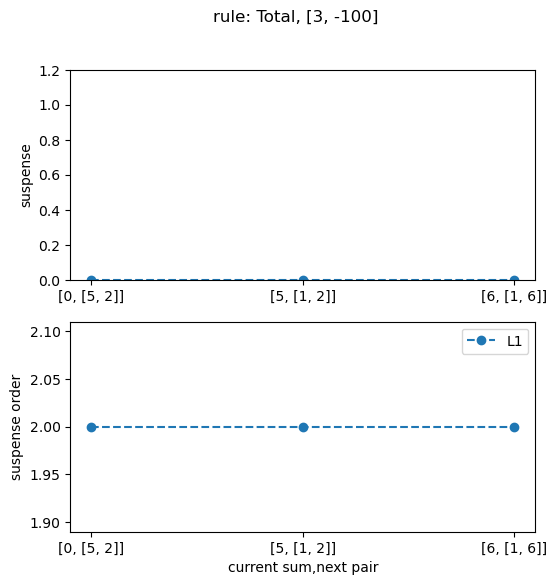

[ 2 -2  1 -4 -6  4 -4  3  2  3]
-1


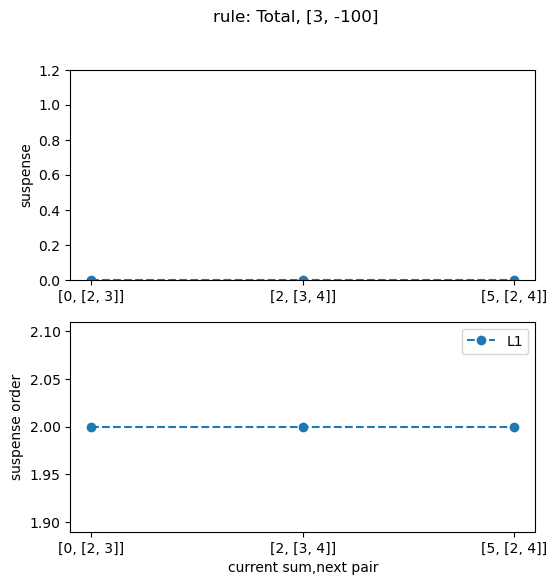

[ 6 -5  0  5  2 -4  4  3  1  4]
-1


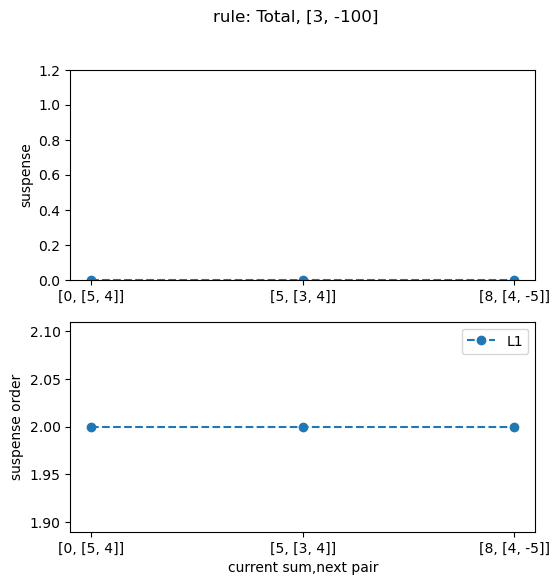

[-3 -2 -5  4  6 -1  4  3 -1  2]
-1


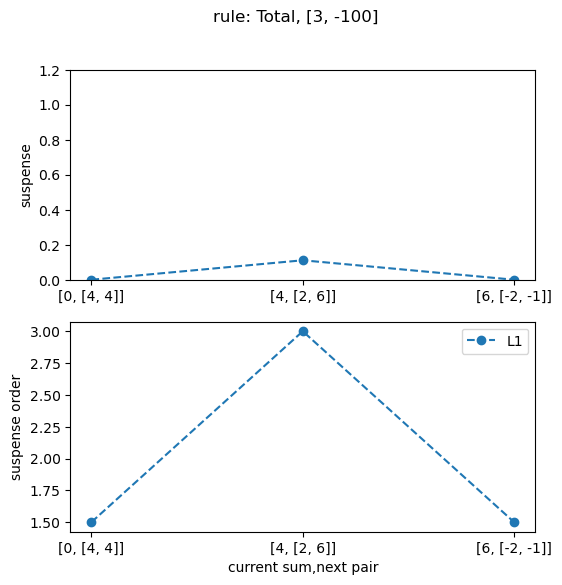

[ 3  4  2  3  1  6 -4  5  6  0]
-1


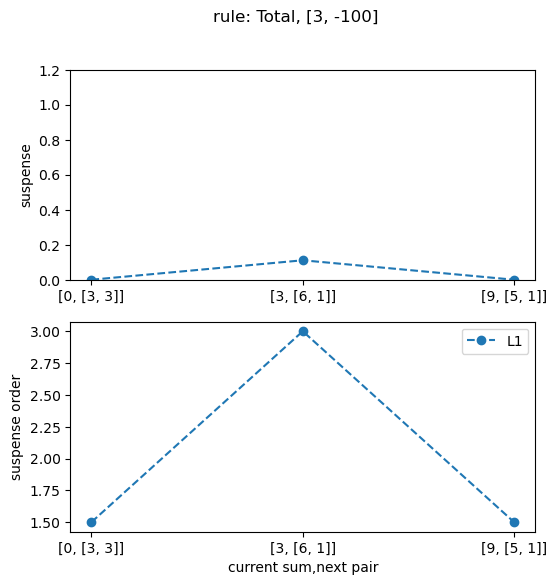

[ 5  3  6 -1  3 -1  4 -2  2  6]
-1


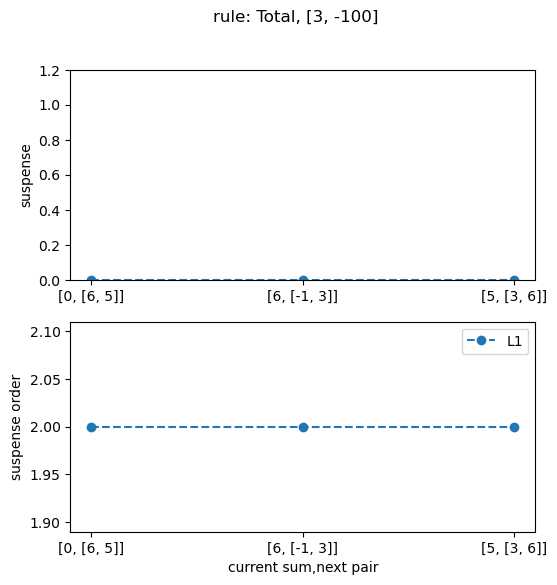

[-3 -2  5 -5 -1  4  5 -4 -6 -7]
1


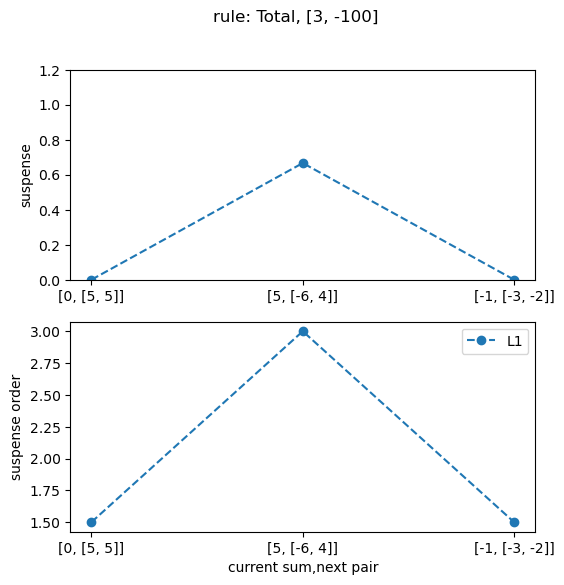

[-5  6  5 -6 -2 -5  1  1 -7  3]
1


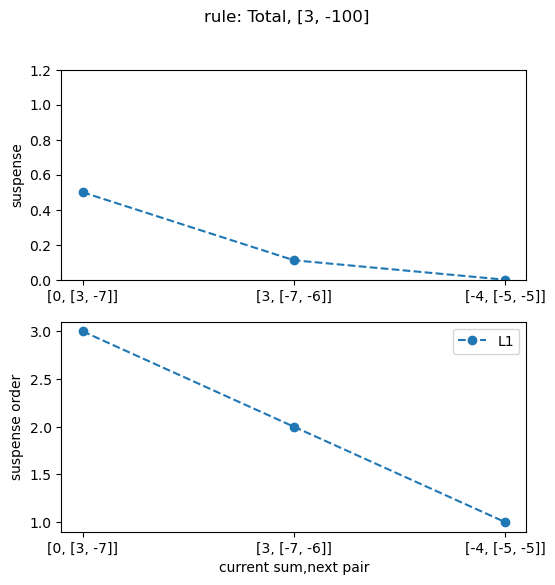

[ 5 -2 -4 -2 -3 -7  5 -6  6  4]
1


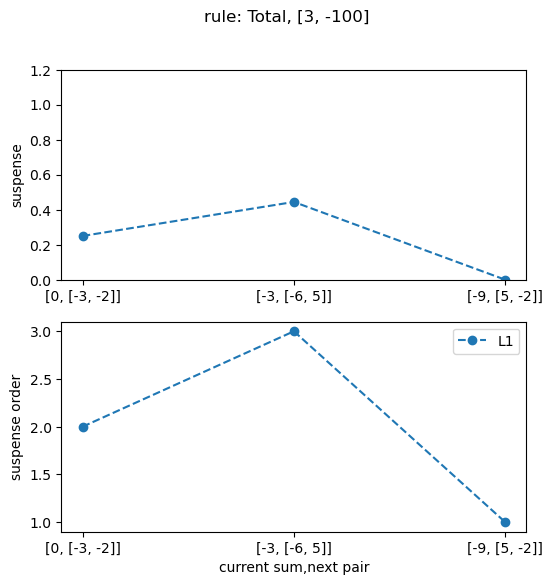

[ 1  5 -7  3 -2  2 -5 -5  6  6]
1


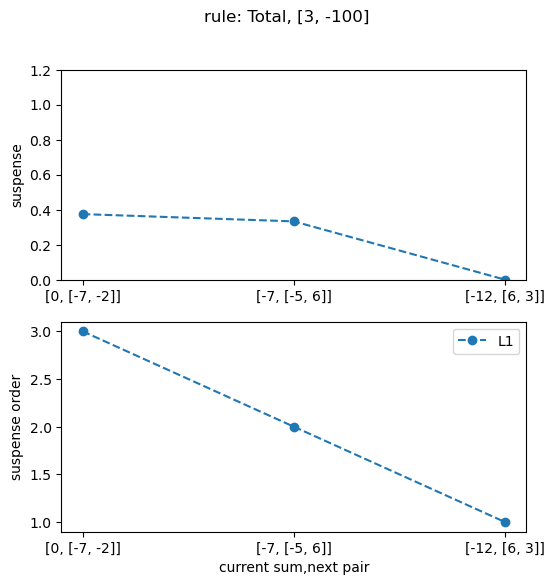

[ 0  1  4  4 -6  2 -6 -5 -1  3]
1


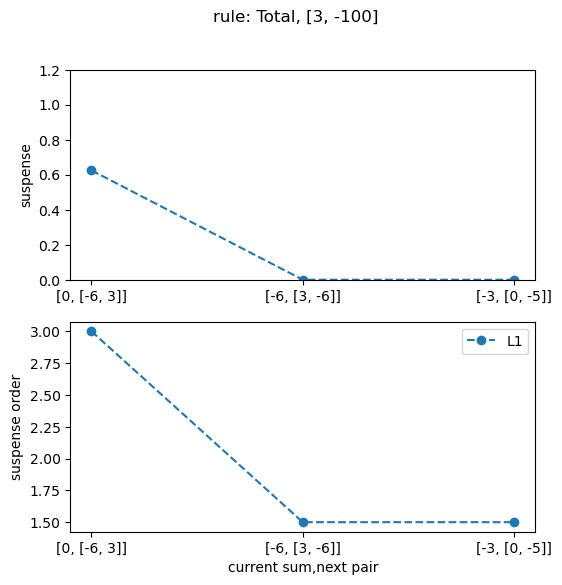

[-3 -4 -1 -5 -2  1  3 -2  6  6]
1


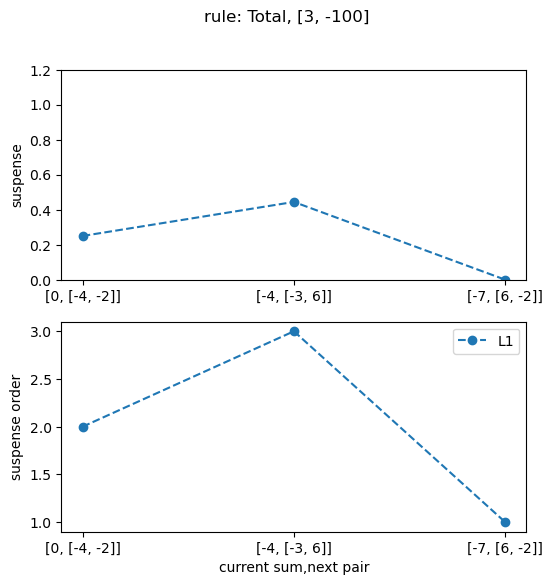

[-2  2  3  6 -7 -1 -5  3  0  5]
-1


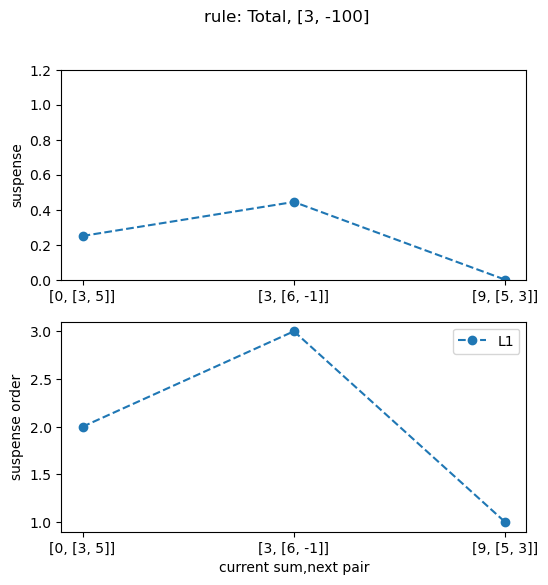

[-2  6 -6  3 -3 -1 -4  4  6 -3]
-1


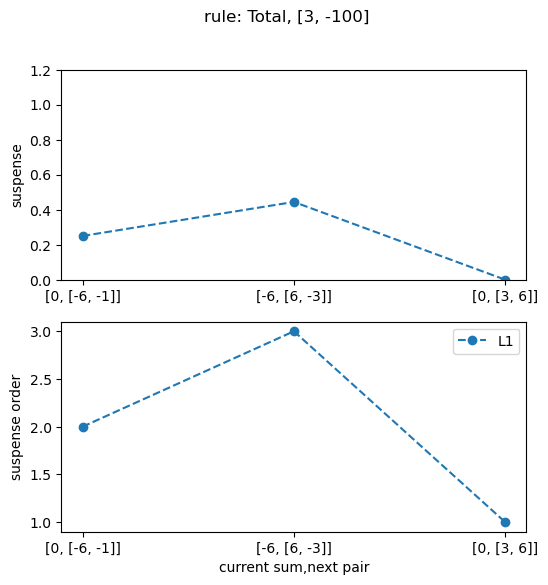

[-3 -6  4 -2  0  5 -2  0  6  5]
-1


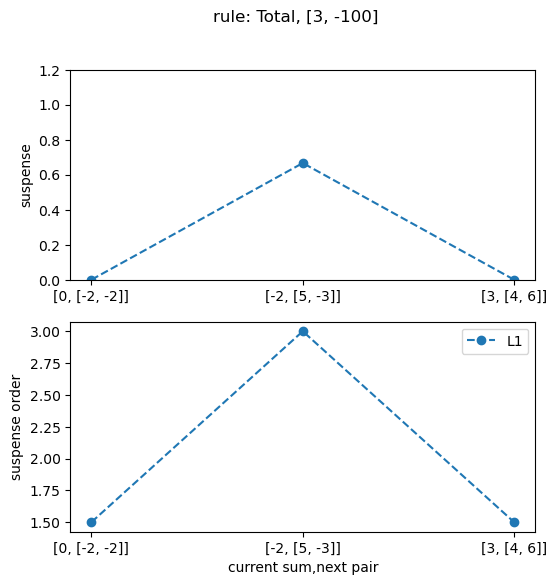

[-6 -1 -3  3 -1 -2  0  6  5  6]
-1


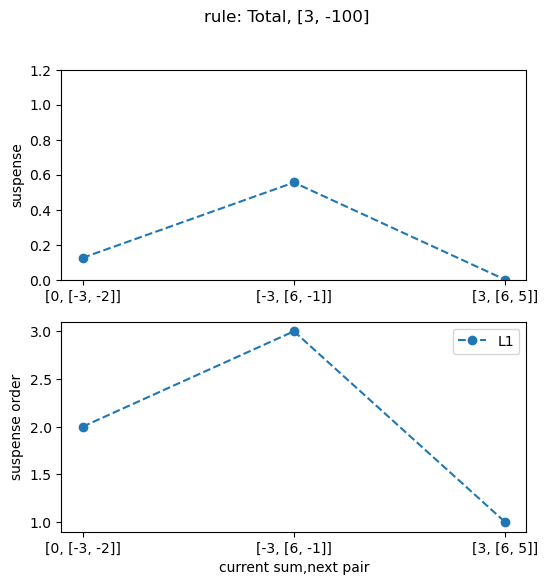

[-4  6  2 -6 -5 -4  3  6  0  4]
-1


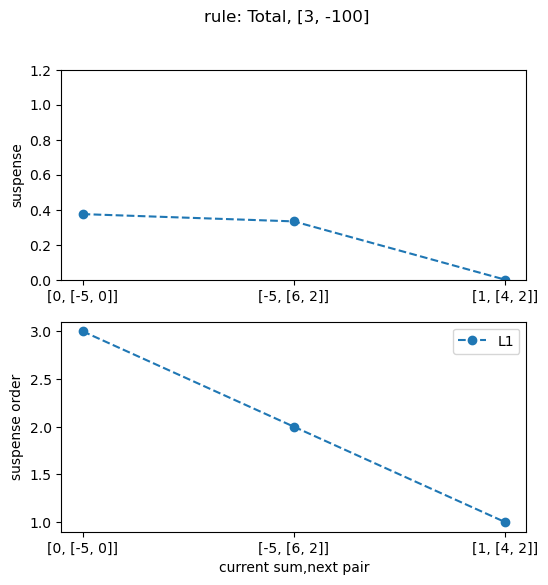

[-1 -7  0 -4  6  1  5  5  4  1]
-1


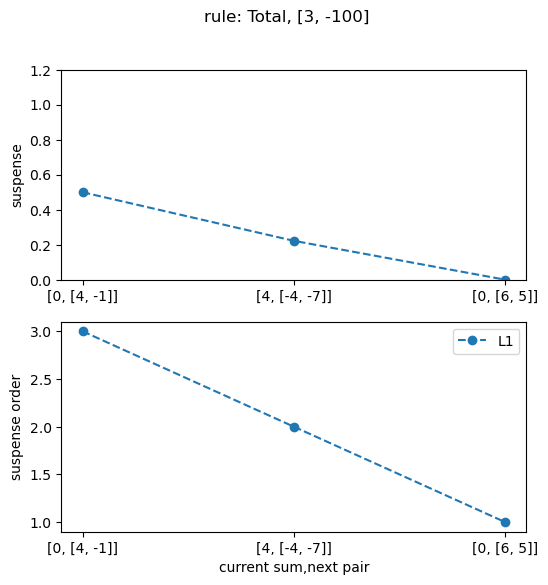

[-6  3  6  5 -3 -4 -6 -7  2  1]
1


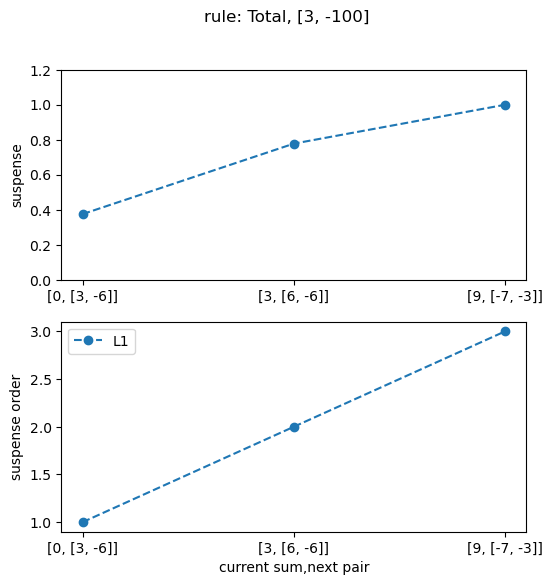

[ 6 -3 -5 -2  2 -4  5  3  3  0]
1


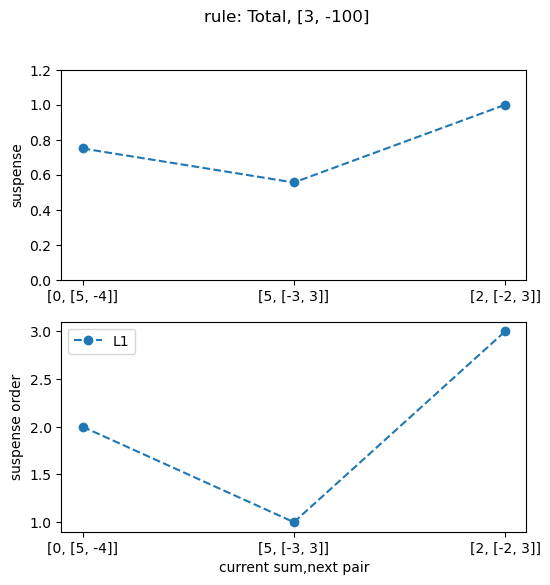

[ 4  5  5 -3 -4  2 -7 -6 -3  2]
1


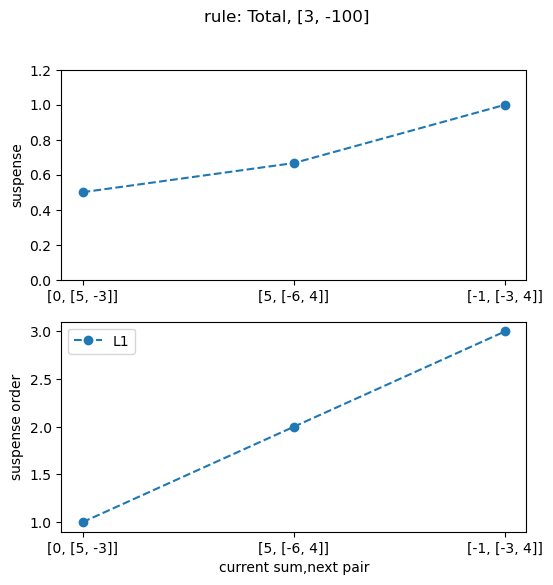

[-4  6  4  2  1 -3  3 -1 -7  4]
1


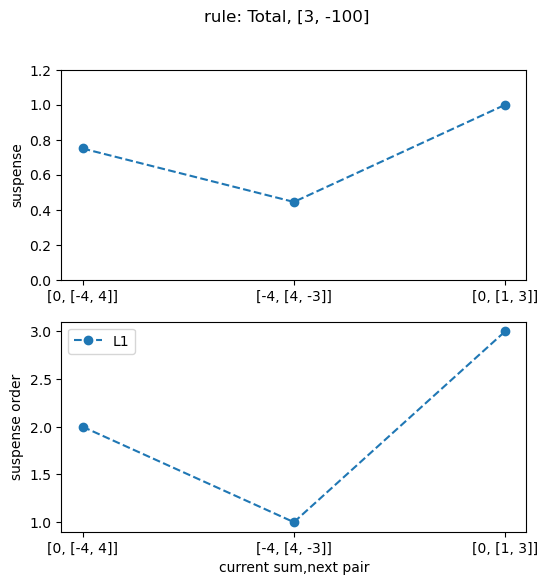

[ 2  5 -1 -6  3 -3  4  0 -4 -5]
1


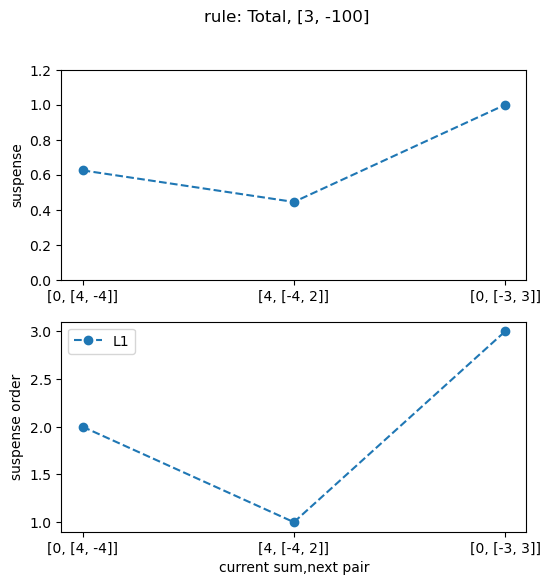

[-1  6 -4  0 -2  2  3 -7  0 -3]
1


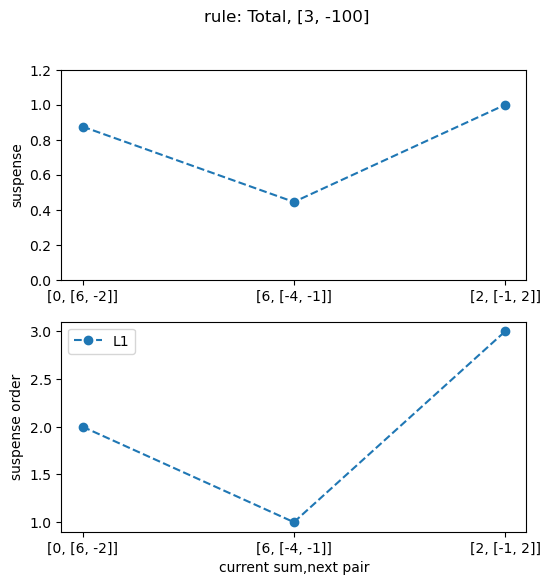

[ 6  5 -4  4 -2  5 -6 -7 -1  3]
-1


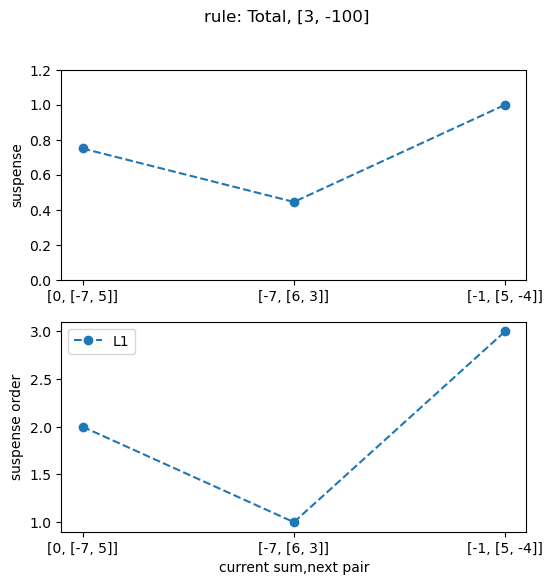

[-5 -4 -2  6 -7  0 -5 -6  3  5]
-1


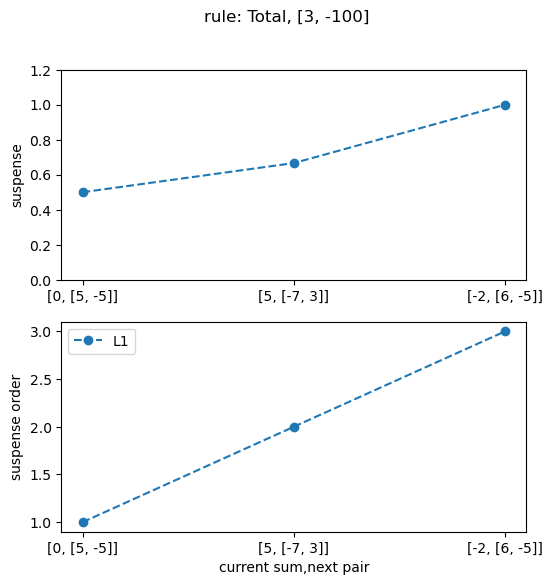

[ 4 -6  2 -4 -2 -3  6 -5  1 -5]
-1


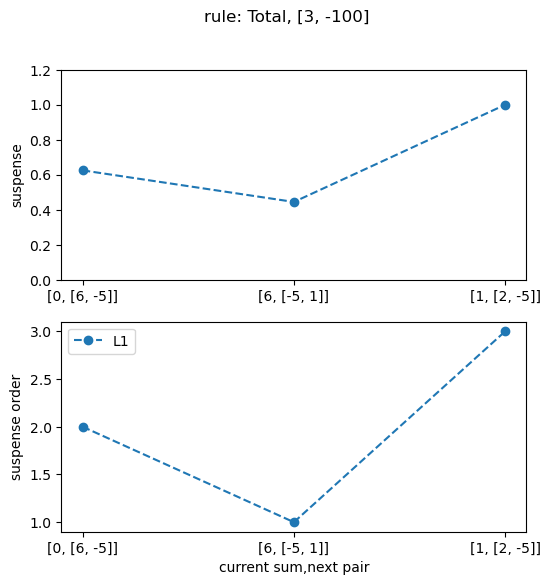

[ 5 -4  6  4 -3  0 -2  3 -1 -5]
-1


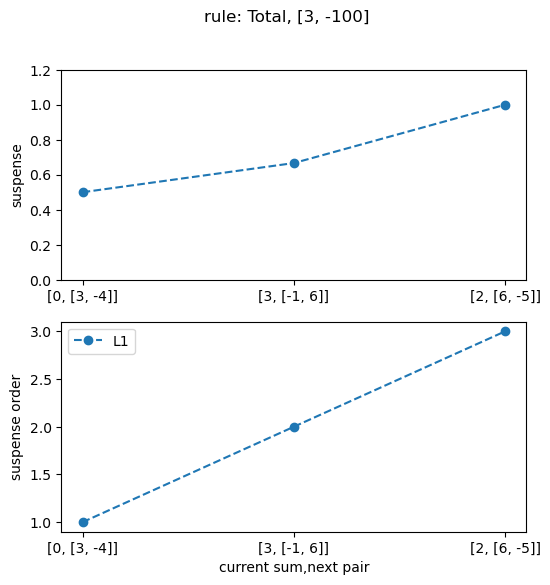

[ 4 -4 -3 -2  5  4  2  3  6 -5]
-1


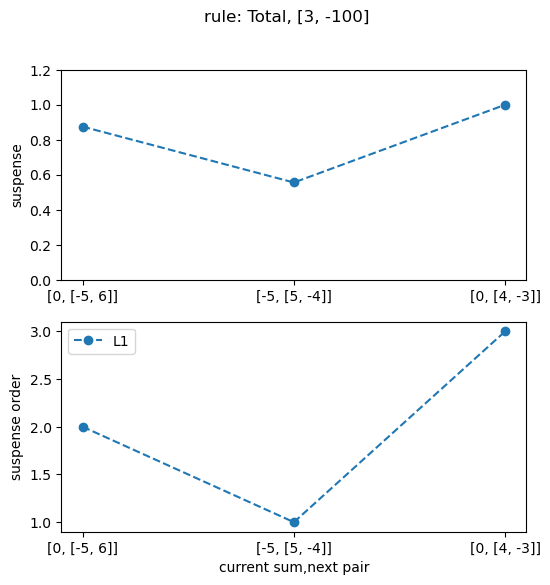

[ 3 -7  6 -6  3 -1  5  4  5  0]
-1


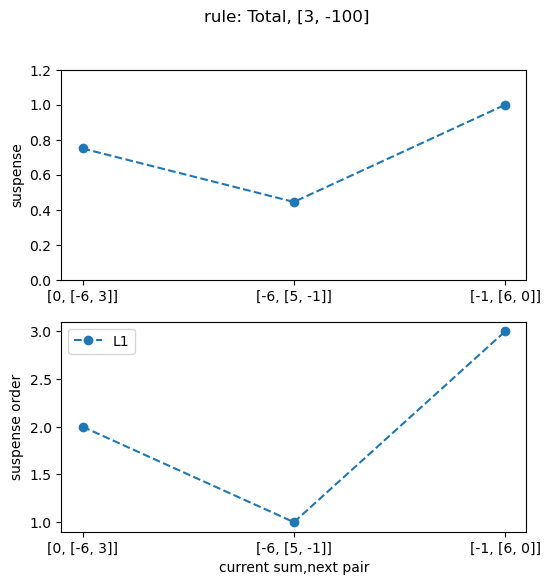

In [334]:
#Display Plots


# Define the ranges for n, v, and k
n_range = range(3) #low, medium, high
v_range = range(2) #win or loose
k_range = range(6) #6 games -> 36 games in total

# Iterate over all combinations of n, v, and k
for n in n_range:
    for v in v_range:
        for k in k_range:
            # Access the game corresponding to the current n, v, and k
            thegame = bestbin[n][v][k]
            
            # Print the deck for reference
            print(thegame['deck_0'])
            print(thegame['iswin'])
            
            # Plot the graph for the current game
            plotsusmodcpr(thegame)

In [335]:
#Save plots

# Define the ranges for n, v, and k
n_range = range(3)  # low, medium, high
v_range = range(2)  # win or loose
k_range = range(6) #6 games -> 36 games in total

# Iterate over all combinations of n, v, and k
for n in n_range:
    for v in v_range:
        for k in k_range:
            # Access the game corresponding to the current n, v, and k
            thegame = bestbin[n][v][k]

            # Save the plot with a descriptive filename
            figfile = f"plot_n{n}_v{v}_k{k}.png"
            plotsusmodcpr(thegame, figfile=figfile)


In [336]:
#Save stim

pickle.dump([bestbin,gmbins],open('finalstim_Apr2_24_small.p','wb'))

In [337]:
# Load the data from the pickle file
bestbin, gmbins = pickle.load(open('finalstim_Apr2_24_small.p', 'rb'))

In [338]:
import openpyxl

# Create a new Excel workbook
wb = openpyxl.Workbook()
sheet = wb.active


# Write the title of the columns for excel file

sheet.cell(row=1, column=1).value = 'Upper and Lower Bound'
sheet.cell(row=1, column=2).value = 'Number of Rounds'
sheet.cell(row=1, column=3).value = 'Is Bust?'

sheet.cell(row=1, column=4).value = 'Deck Composition 0'
sheet.cell(row=1, column=5).value = 'Pair 1'
sheet.cell(row=1, column=6).value = 'Suspense Pair 1'

sheet.cell(row=1, column=7).value = 'Deck Composition 1'
sheet.cell(row=1, column=8).value = 'Pair 2'
sheet.cell(row=1, column=9).value = 'Suspense Pair 2'

sheet.cell(row=1, column=10).value = 'Deck Composition 2'
sheet.cell(row=1, column=11).value = 'Pair 3'
sheet.cell(row=1, column=12).value = 'Suspense Pair 3'

sheet.cell(row=1, column=13).value = 'Overall Suspense'
sheet.cell(row=1, column=14).value = 'Is Win?'
sheet.cell(row=1, column=15).value = 'Fig File'
sheet.cell(row=1, column=16).value = 'Game Type'


#Assign game type labels on last column of sheet

###LOW SUSPENSE WIN
rows_to_assign = range(2, 8)

#Assign the value to the specified range of cells
for row in rows_to_assign:
    sheet.cell(row=row, column=16).value = "Low Suspense Games - Winning"


###LOW SUSPENSE LOSE
rows_to_assign = range(8, 14)

#Assign the value to the specified range of cells
for row in rows_to_assign:
    sheet.cell(row=row, column=16).value = "Low Suspense Games - Losing"



###MID SUSPENSE WIN
rows_to_assign = range(14, 20)

#Assign the value to the specified range of cells
for row in rows_to_assign:
    sheet.cell(row=row, column=16).value = "Mid Suspense Games - Winning"



###MID SUSPENSE LOSE
rows_to_assign = range(20, 26)

#Assign the value to the specified range of cells
for row in rows_to_assign:
    sheet.cell(row=row, column=16).value = "Mid Suspense Games - Losing"



###HIGH SUSPENSE WIN
rows_to_assign = range(26, 32)

#Assign the value to the specified range of cells
for row in rows_to_assign:
    sheet.cell(row=row, column=16).value = "High Suspense Games - Winning"


###HIGH SUSPENSE LOSE
rows_to_assign = range(32, 38)

#Assign the value to the specified range of cells
for row in rows_to_assign:
    sheet.cell(row=row, column=16).value = "High Suspense Games - Lose"




#FILL EXCEL SHEET WITH GAMES:
    
# Define the ranges for n, v, and k
n_range = range(3) # low, medium, high
v_range = range(2) # win or lose
k_range = range(6) # 6 games -> 36 games in total


# Iterate over all combinations of n, v, and k
for n in n_range:
    for v in v_range:
        for k in k_range:
            # Access the game corresponding to the current n, v, and k
            thegame = bestbin[n][v][k]


            #Convert the ublb array into a string
            ublb = ','.join(map(str, thegame['ublb']))

            #Convert the deck array into a string
            deck_1_str = ','.join(map(str, thegame['deck_0']))
            deck_2_str = ','.join(map(str, thegame['deck_1']))
            deck_3_str = ','.join(map(str, thegame['deck_2']))

            #Convert the pairseq array into 3 strings
            pair_1 = ','.join(map(str, thegame['pairseq'][0]))
            pair_2 = ','.join(map(str, thegame['pairseq'][1]))
            pair_3 = ','.join(map(str, thegame['pairseq'][2]))
    

            #Convert suspcr L1 list to a string
            overall_suspense = ','.join(map(str, thegame['suscpr']['L1']))
            susp_pair_1 = thegame['suscpr']['L1'][0]
            susp_pair_2 = thegame['suscpr']['L1'][1]
            susp_pair_3 = thegame['suscpr']['L1'][2]
    

            #Save fig_file name to link to document
            figfile = f"plot_n{n}_v{v}_k{k}.png"


            # Write the value to the Excel sheet
            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=1).value = ublb
            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=2).value = thegame['nmax']
            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=3).value = thegame['isbust']
            
            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=4).value = deck_1_str
            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=5).value = pair_1
            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=6).value = susp_pair_1

            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=7).value = deck_2_str
            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=8).value = pair_2
            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=9).value = susp_pair_2

            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=10).value = deck_3_str
            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=11).value = pair_3
            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=12).value = susp_pair_3

            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=13).value = overall_suspense
            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=14).value = thegame['iswin']
            sheet.cell(row=n*len(v_range)*len(k_range) + v*len(k_range) + k + 2, column=15).value = figfile



# Save the workbook
wb.save("stimuli_No_Repl_3_trials_2Apr24.xlsx")

In [339]:
import csv

# Define the filename for the CSV file
filename = "stimuli_No_Repl_3_trials_2Apr24.csv"

# Define the data headers
headers = [
    'Upper and Lower Bound', 'Number of Rounds', 'Is Bust?',
    'Deck Composition 0', 'Pair 1', 'Suspense Pair 1',
    'Deck Composition 1', 'Pair 2', 'Suspense Pair 2',
    'Deck Composition 2', 'Pair 3', 'Suspense Pair 3',
    'Overall Suspense', 'Is Win?', 'Fig File', 'Game Type'
]

# Create a list to hold all rows of data
data_rows = []

# Define the ranges for n, v, and k
n_range = range(3) # low, medium, high
v_range = range(2) # win or lose
k_range = range(6) # 6 games -> 36 games in total

# Fill the data rows
for n in n_range:
    for v in v_range:
        for k in k_range:
            thegame = bestbin[n][v][k]

            # Convert the ublb array into a string
            ublb = ','.join(map(str, thegame['ublb']))

            #Convert the deck array into a string
            deck_1_str = ','.join(map(str, thegame['deck_0']))
            deck_2_str = ','.join(map(str, thegame['deck_1']))
            deck_3_str = ','.join(map(str, thegame['deck_2']))
    

            # Convert the pairseq array into 3 strings
            pair_1 = ','.join(map(str, thegame['pairseq'][0]))
            pair_2 = ','.join(map(str, thegame['pairseq'][1]))
            pair_3 = ','.join(map(str, thegame['pairseq'][2]))
    
            # Convert suspcr L1 list to a string
            overall_suspense = ','.join(map(str, thegame['suscpr']['L1']))
            susp_pair_1 = thegame['suscpr']['L1'][0]
            susp_pair_2 = thegame['suscpr']['L1'][1]
            susp_pair_3 = thegame['suscpr']['L1'][2]
    

            # Save fig_file name to link to document
            figfile = f"plot_n{n}_v{v}_k{k}.png"

            # Determine game type based on n, v, and k
            if n == 0:
                if v == 0:
                    game_type = "Low Suspense Games - Winning"
                else:
                    game_type = "Low Suspense Games - Losing"
            elif n == 1:
                if v == 0:
                    game_type = "Mid Suspense Games - Winning"
                else:
                    game_type = "Mid Suspense Games - Losing"
            else:
                if v == 0:
                    game_type = "High Suspense Games - Winning"
                else:
                    game_type = "High Suspense Games - Losing"

            # Append row to data rows
            data_rows.append([
                ublb, thegame['nmax'], thegame['isbust'], 
                deck_1_str, pair_1, susp_pair_1, 
                deck_2_str, pair_2, susp_pair_2, 
                deck_3_str, pair_3, susp_pair_3, 
                overall_suspense, thegame['iswin'], figfile, game_type
            ])

# Write data to CSV file with semicolon as delimiter
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=';')
    
    # Write headers
    csvwriter.writerow(headers)
    
    # Write data rows
    csvwriter.writerows(data_rows)

print(f'Data has been saved to {filename}.')

Data has been saved to stimuli_No_Repl_3_trials_2Apr24.csv.


### Pseudo randomisation of games

- Divide games in 2 groups (18 games per group), each group should have a similar cumulated mean suspense and similar variance

In [340]:
#calculate mean function
#divide into groups and get game order per group
#randomise order in java per participant!

In [341]:
# For each group:
# Choose randomly 3 games from Low Suspense Games - Winning category -> bestbin[0][0][k]

low_susp_win = np.arange(6)
np.random.shuffle(low_susp_win)
low_susp_win_g1=low_susp_win[:3]
low_susp_win_g2=low_susp_win[3:]
print(low_susp_win_g1)
print(low_susp_win_g2)

low_susp_games_win_g1 = []
for k in low_susp_win_g1:
    games = bestbin[0][0][k]
    low_susp_games_win_g1.append(games)
    

low_susp_games_win_g2 = []
for k in low_susp_win_g2:
    games = bestbin[0][0][k]
    low_susp_games_win_g2.append(games)
    

# Choose randomly 3 games from Low Suspense Games - Losing category -> bestbin[0][1][k]
    
low_susp_lose = np.arange(6)
np.random.shuffle(low_susp_lose)
low_susp_lose_g1=low_susp_lose[:3]
low_susp_lose_g2=low_susp_lose[3:]
print(low_susp_lose_g1)
print(low_susp_lose_g2)

low_susp_games_lose_g1 = []
for k in low_susp_lose_g1:
    games = bestbin[0][1][k]
    low_susp_games_lose_g1.append(games)
    

low_susp_games_lose_g2 = []
for k in low_susp_lose_g2:
    games = bestbin[0][1][k]
    low_susp_games_lose_g2.append(games)
    
    

# Choose randomly 3 games from Mid Suspense Games - Winning category -> bestbin[1][0][k]
    

mid_susp_win = np.arange(6)
np.random.shuffle(mid_susp_win)
mid_susp_win_g1=mid_susp_win[:3]
mid_susp_win_g2=mid_susp_win[3:]
print(mid_susp_win_g1)
print(mid_susp_win_g2)


mid_susp_games_win_g1 = []
for k in mid_susp_win_g1:
    games = bestbin[1][0][k]
    mid_susp_games_win_g1.append(games)
    

mid_susp_games_win_g2 = []
for k in mid_susp_win_g2:
    games = bestbin[1][0][k]
    mid_susp_games_win_g2.append(games)


# Choose randomly 3 games from Mid Suspense Games - Losing category -> bestbin[1][1][k]
    

mid_susp_lose = np.arange(6)
np.random.shuffle(mid_susp_lose)
mid_susp_lose_g1=mid_susp_lose[:3]
mid_susp_lose_g2=mid_susp_lose[3:]
print(mid_susp_lose_g1)
print(mid_susp_lose_g2)

mid_susp_games_lose_g1 = []
for k in mid_susp_lose_g1:
    games = bestbin[1][1][k]
    mid_susp_games_lose_g1.append(games)
    

mid_susp_games_lose_g2 = []
for k in mid_susp_lose_g2:
    games = bestbin[1][1][k]
    mid_susp_games_lose_g2.append(games)
    
    
    
# Choose randomly 3 games from High Suspense Games - Winning category -> bestbin[2][0][k]
high_susp_win = np.arange(6)
np.random.shuffle(high_susp_win)
high_susp_win_g1=high_susp_win[:3]
high_susp_win_g2=high_susp_win[3:]
print(high_susp_win_g1)
print(high_susp_win_g2)


high_susp_games_win_g1 = []
for k in high_susp_win_g1:
    games = bestbin[2][0][k]
    high_susp_games_win_g1.append(games)
    

high_susp_games_win_g2 = []
for k in high_susp_win_g2:
    games = bestbin[2][0][k]
    high_susp_games_win_g2.append(games)



# Choose randomly 3 games from High Suspense Games - Losing category -> bestbin[2][1][k]
    


high_susp_lose = np.arange(6)
np.random.shuffle(high_susp_lose)
high_susp_lose_g1=high_susp_lose[:3]
high_susp_lose_g2=high_susp_lose[3:]
print(high_susp_lose_g1)
print(high_susp_lose_g2)

high_susp_games_lose_g1 = []
for k in high_susp_lose_g1:
    games = bestbin[2][1][k]
    high_susp_games_lose_g1.append(games)
    

high_susp_games_lose_g2 = []
for k in high_susp_lose_g2:
    games = bestbin[2][1][k]
    high_susp_games_lose_g2.append(games)
    
    


[5 4 3]
[2 1 0]
[0 5 1]
[4 2 3]
[3 1 4]
[2 5 0]
[0 2 1]
[4 3 5]
[1 0 3]
[2 5 4]
[5 0 4]
[1 3 2]


In [342]:
#Put all group 1 games in one tuple
group_1 = (low_susp_games_win_g1, low_susp_games_lose_g1, mid_susp_games_win_g1, mid_susp_games_lose_g1, high_susp_games_win_g1, high_susp_games_lose_g1)

#Get 1D array containing group 1 games indexes
group_1_index = (low_susp_win_g1, (low_susp_lose_g1)+6, (mid_susp_win_g1)+12, (mid_susp_lose_g1)+18, (high_susp_win_g1)+24, (high_susp_lose_g1)+30)
group_1_index= np.concatenate(group_1_index)
group_1_index.flatten()

print(group_1_index)
print(sorted(group_1_index))

#Repeat for group 2
group_2 = (low_susp_games_win_g2, low_susp_games_lose_g2, mid_susp_games_win_g2, mid_susp_games_lose_g2, high_susp_games_win_g2, high_susp_games_lose_g2)
group_2_index = (low_susp_win_g2, (low_susp_lose_g2)+6, (mid_susp_win_g2)+12, (mid_susp_lose_g2)+18, (high_susp_win_g2)+24, (high_susp_lose_g2)+30)
group_2_index= np.concatenate(group_2_index)
group_2_index.flatten()

print(group_2_index)
print(sorted(group_2_index))

[ 5  4  3  6 11  7 15 13 16 18 20 19 25 24 27 35 30 34]
[3, 4, 5, 6, 7, 11, 13, 15, 16, 18, 19, 20, 24, 25, 27, 30, 34, 35]
[ 2  1  0 10  8  9 14 17 12 22 21 23 26 29 28 31 33 32]
[0, 1, 2, 8, 9, 10, 12, 14, 17, 21, 22, 23, 26, 28, 29, 31, 32, 33]


In [343]:
def suspense_sum(group): 

    # Define the ranges for v, and k
    v_range = range(6) # game type
    k_range = range(3) # 3 games -> 18 games in total

    all_sums= []
    
        # Fill the data rows
    for n in n_range:
        for v in v_range:
            for k in k_range:
                thegame = group[v][k]

                #calculate single game sun
                game_sum  = np.sum(thegame['suscpr']['L1'])
                #append sum to overall array
                all_sums.append(game_sum)


    #calculate overall sum and variance of suspense for the group
    total_suspense = np.sum(all_sums)
    var_suspense = np.var(all_sums)

    return total_suspense, var_suspense

In [344]:
print(suspense_sum(group_1))
print(suspense_sum(group_2))

(52.416666666666664, 0.8899581809175432)
(52.041666666666664, 0.7905765365416859)
